In [1]:
# Use seaborn for pairplot
!pip install -q seaborn

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


# set print options
np.set_printoptions(precision=3, suppress=True)

In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.4.1


# Step 1. Load data (Initial preparations)

In [4]:
path = '../data/auto-mpg.csv'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(path, names=column_names, na_values='?', comment='\t', sep=' ', skipinitialspace=True)

In [5]:
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [6]:
# check all input values are valid
dataset.isna().sum()


MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

Drop rows containing NaN values

In [7]:
before = len(dataset)
dataset = dataset.dropna()
after = len(dataset)
print(f'dropped {before - after} records')
print(f'clean set: {after} records')

dropped 6 records
clean set: 392 records


Split Origin column into 3 columns

In [8]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

In [9]:
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


# Step 2. Split initial data set into 2(3) parts: train dataset and test dataset



In [10]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)
print(f'train set: {len(train_dataset)} records')
print(f'test set: {len(test_dataset)} records')


train set: 314 records
test set: 78 records


# Step 2a. Data retrospection



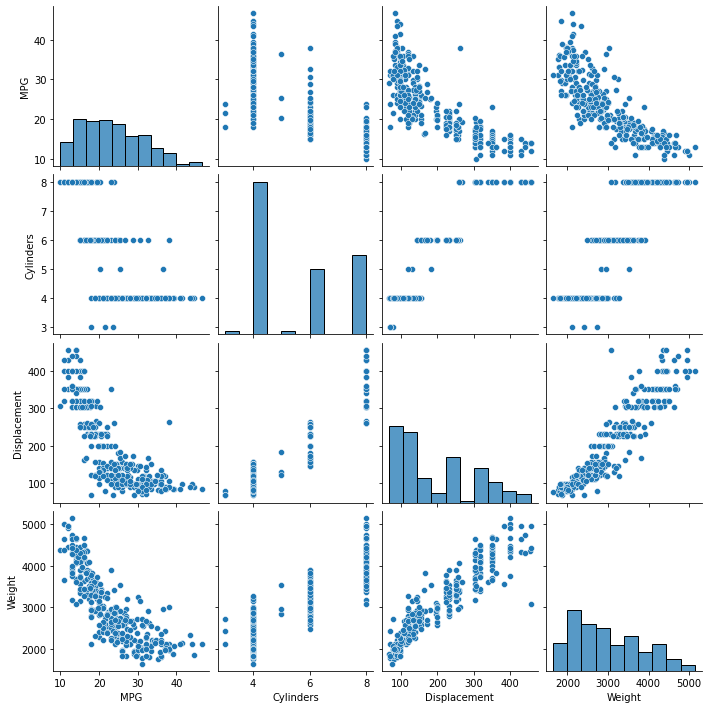

In [11]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='hist')

In [12]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


# Step 3. Define features and labels

Separate the target value, the "label", from the features. This label is the value that you will train the model to predict.

In [13]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

# Step 4. Normalize data

In the table of statistics it's easy to see how different the ranges of each feature are.

In [14]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642
Europe,0.178344,0.383413
Japan,0.197452,0.398712
USA,0.624204,0.485101


## Use normalization layer from preprocessing package

The first step is to create the layer:

In [15]:
normalizer = preprocessing.Normalization()

Then `.adapt()` it to the data:

In [16]:
normalizer.adapt(np.array(train_features))

This calculates the mean and variance, and stores them in the layer. 

In [17]:
print(normalizer.mean.numpy())

[   5.478  195.318  104.869 2990.252   15.559   75.898    0.178    0.197
    0.624]


When the layer is called it returns the input data, with each feature independently normalized:

In [18]:
first = np.array(train_features[:1]) # get 1st line

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]]

Normalized: [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


# Step 5. Linear regression



### One Variable



First create the horsepower `Normalization` layer:

In [19]:
horsepower = np.array(train_features['Horsepower']) # extract 1 column from all set

horsepower_normalizer = preprocessing.Normalization(input_shape=[1,])
horsepower_normalizer.adapt(horsepower)

Build the sequential model (This model will predict MPG from Horsepower):

In [20]:
horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
])

horsepower_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [21]:
horsepower_model.predict(horsepower[:10])

array([[ 0.749],
       [ 0.423],
       [-1.383],
       [ 1.05 ],
       [ 0.95 ],
       [ 0.373],
       [ 1.125],
       [ 0.95 ],
       [ 0.247],
       [ 0.423]], dtype=float32)

Once the model is built, configure the training procedure using the `Model.compile()` method. The most important arguments to compile are the `loss` and the `optimizer` since these define what will be optimized (`mean_absolute_error`) and how (using the `optimizers.Adam`).

In [22]:
horsepower_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

Once the training is configured, use `Model.fit()` to execute the training:

In [23]:
%%time
history = horsepower_model.fit(
    train_features['Horsepower'], train_labels,
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

Wall time: 4.49 s


Visualize the model's training progress using the statistics in the `history` object.

In [24]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,3.801991,4.200114,95
96,3.802585,4.199963,96
97,3.803564,4.187710,97
98,3.805794,4.180610,98
99,3.803738,4.203300,99


In [25]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

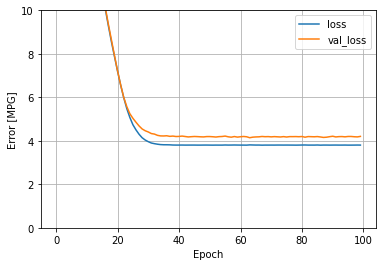

In [26]:
plot_loss(history) # Note the typical graph showing how model is learning (after 40 epochs convergence was reached)

In [27]:
test_results = {}

test_results['horsepower_model'] = horsepower_model.evaluate(
    test_features['Horsepower'],
    test_labels, verbose=0)

Compare the model's predictions with the input:

In [28]:
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

In [29]:
def plot_horsepower(x, y):
  plt.scatter(train_features['Horsepower'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.legend()

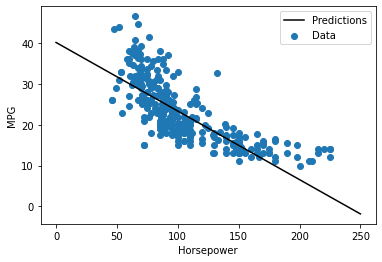

In [30]:
plot_horsepower(x,y)

### Multiple variables

Note: this time use the `Normalization` layer that was adapted to the whole dataset.

In [31]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

When you call this model on a batch of inputs, it produces `units=1` outputs for each example.

In [32]:
linear_model.predict(train_features[:10])

array([[ 1.065],
       [ 2.213],
       [-1.579],
       [ 3.037],
       [ 0.404],
       [ 1.662],
       [ 0.596],
       [ 1.088],
       [ 0.483],
       [-1.369]], dtype=float32)

When you call the model it's weight matrices will be built. Now you can see that the `kernel` (the $m$ in $y=mx+b$) has a shape of `(9,1)`.

In [33]:
linear_model.layers[1].kernel

<tf.Variable 'dense_1/kernel:0' shape=(9, 1) dtype=float32, numpy=
array([[-0.748],
       [ 0.752],
       [-0.744],
       [-0.22 ],
       [ 0.232],
       [ 0.739],
       [-0.606],
       [-0.751],
       [ 0.231]], dtype=float32)>

Use the same `compile` and `fit` calls as for the single input `horsepower` model:

In [34]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [35]:
%%time
history = linear_model.fit(
    train_features, train_labels, 
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

Wall time: 3.81 s


Using all the inputs achieves a much lower training and validation error than the `horsepower` model: 

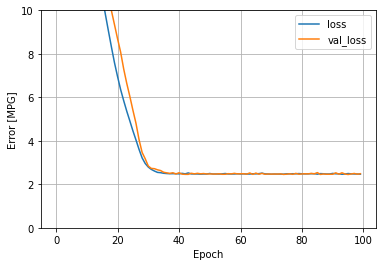

In [36]:
plot_loss(history)

Collect the results on the test set, for later:

In [37]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

# Step 6. Performance

In [38]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.655036
linear_model,2.516188


# Step 7. Predictions

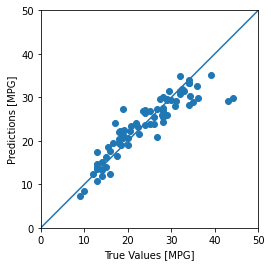

In [39]:
test_predictions = linear_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


# Step 8. Analysis of results


Obviously, ideal predictions results must be plotted exactly on line. On real data there always will be some discrepancy